In [1]:
!pip install neuralforecast
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.5/221.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.5/223.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 40.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import lightning.pytorch as pl
import neuralforecast
from neuralforecast.models import NBEATS
from neuralforecast.losses.pytorch import MAE

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hourly-electricity-consumption-and-production/electricityConsumptionAndProductioction.csv


# Data

In [3]:
df = pd.read_csv('/kaggle/input/hourly-electricity-consumption-and-production/electricityConsumptionAndProductioction.csv',
                 parse_dates=['DateTime'])
df.drop_duplicates(inplace=True)
print(f'data has {df.shape[0]} rows and {df.shape[1]} columns')
df.head()

data has 46007 rows and 10 columns


,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


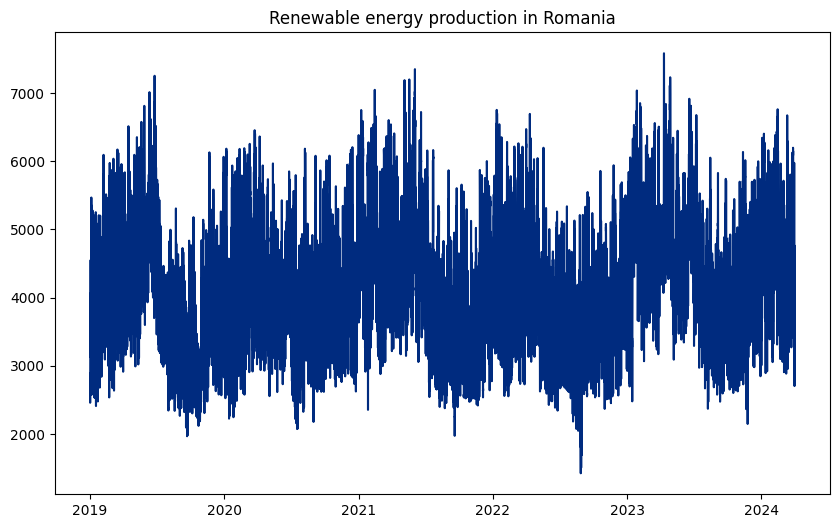

In [4]:
df['Renewable'] = df['Production'] - df['Coal'] - df['Oil and Gas']

plt.figure(figsize=(10, 6))
plt.plot(df.DateTime, df.Renewable, color='#002B7F')
plt.title('Renewable energy production in Romania');

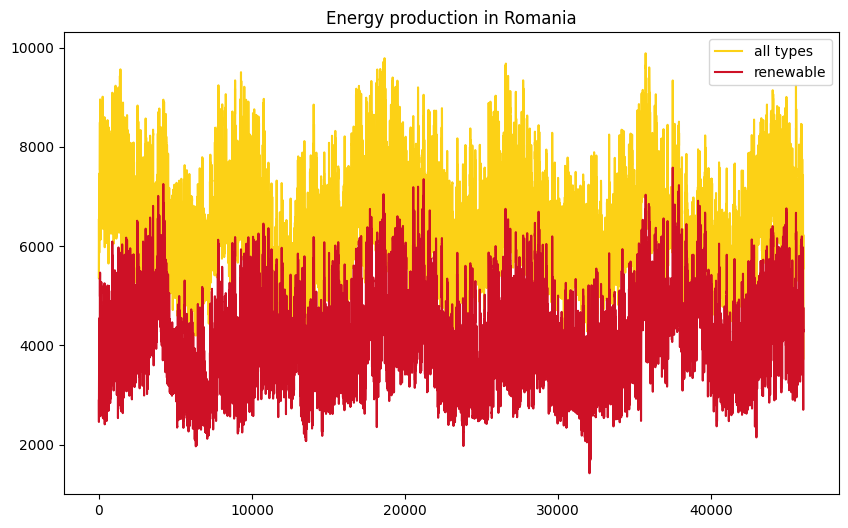

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(df.Production, color='#FCD116', label='all types')
plt.plot(df.Renewable, color='#CE1126', label='renewable')
plt.legend()
plt.title('Energy production in Romania');

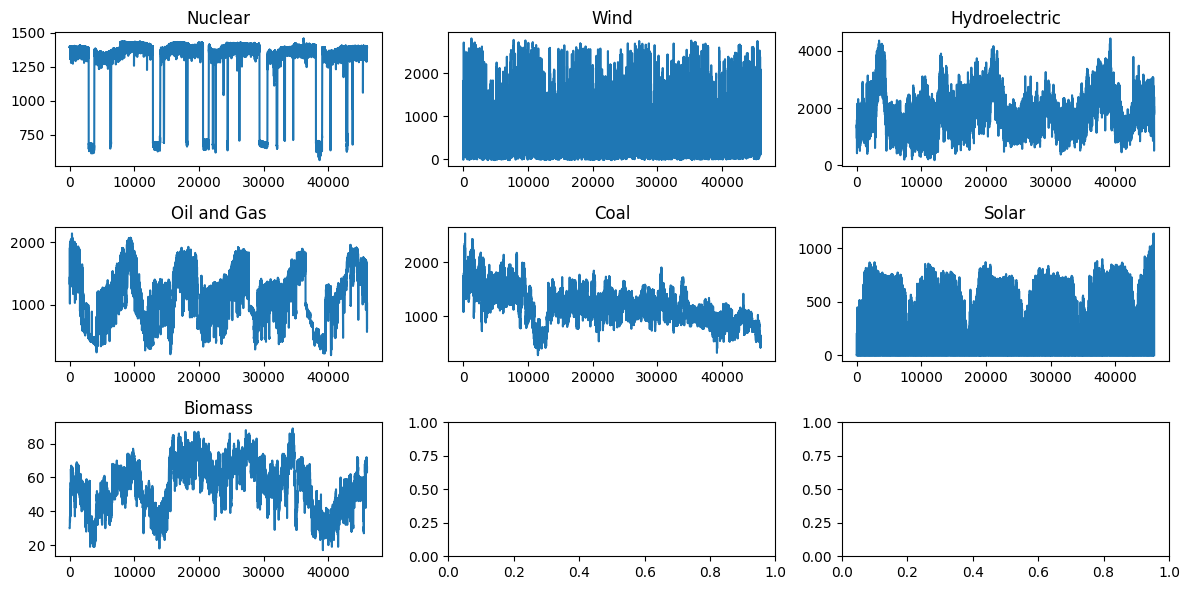

In [6]:
_, ax = plt.subplots(3, 3, tight_layout=True, figsize=(12,6))
for i, a in zip(np.arange(3, 10), ax.flat):
    a.plot(df.iloc[:, i])
    a.set_title(df.columns[i]);

## Preprocessing

In [7]:
df['unique_id'] = df.DateTime.dt.year

In [8]:
df = df.loc[df.unique_id!=2024, ['DateTime', 'unique_id', 'Renewable']]

In [9]:
#change dtypes
df['Renewable'] = df.Renewable.astype('float32')

In [10]:
df

,DateTime,unique_id,Renewable
0,2019-01-01 00:00:00,2019,2887.0
1,2019-01-01 01:00:00,2019,2631.0
2,2019-01-01 02:00:00,2019,2595.0
3,2019-01-01 03:00:00,2019,2590.0
4,2019-01-01 04:00:00,2019,2542.0
...,...,...,...
43823,2023-12-31 19:00:00,2023,4753.0
43824,2023-12-31 20:00:00,2023,4776.0
43825,2023-12-31 21:00:00,2023,4909.0
43826,2023-12-31 22:00:00,2023,4187.0


## Preprocessing: preparing the data for training and testing

In [11]:
OUR_HORIZON = 24*30*3

In [12]:
df.rename({'Renewable': 'y', 'DateTime': 'ds'}, axis='columns', inplace=True)
df

,ds,unique_id,y
0,2019-01-01 00:00:00,2019,2887.0
1,2019-01-01 01:00:00,2019,2631.0
2,2019-01-01 02:00:00,2019,2595.0
3,2019-01-01 03:00:00,2019,2590.0
4,2019-01-01 04:00:00,2019,2542.0
...,...,...,...
43823,2023-12-31 19:00:00,2023,4753.0
43824,2023-12-31 20:00:00,2023,4776.0
43825,2023-12-31 21:00:00,2023,4909.0
43826,2023-12-31 22:00:00,2023,4187.0


In [13]:
# splitting
train = df.iloc[:-(3*OUR_HORIZON), :]
test = df.iloc[-(3*OUR_HORIZON):, :]

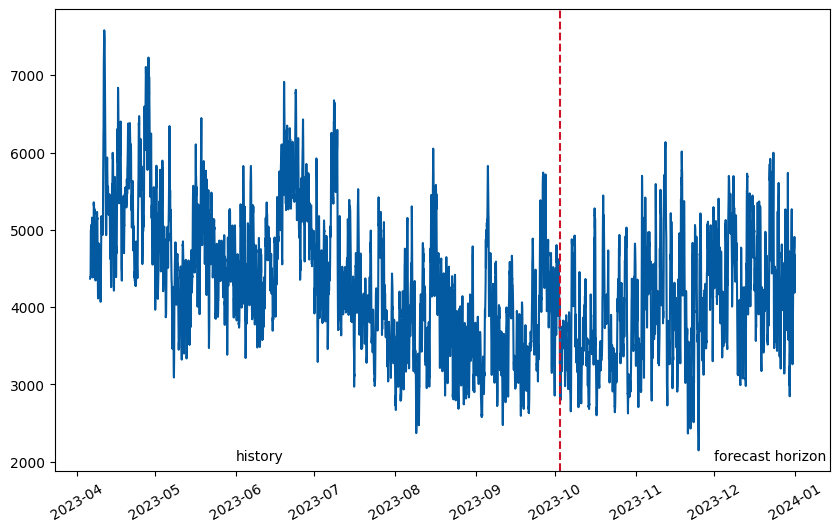

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(test.ds, test.y, color='#045AA0')
plt.axvline(test.ds.iloc[-OUR_HORIZON], linestyle='--', color='#CE1126')
plt.text(x=pd.to_datetime('2023-06-01'), y=2024, s='history')
plt.text(x=pd.to_datetime('2023-12-01'), y=2024, s='forecast horizon')
plt.tick_params(axis='x', rotation=30);

# NBEATS

In [15]:
nbeats = NBEATS(h=OUR_HORIZON, input_size=3*OUR_HORIZON, n_harmonics=2, n_polynomials=2, 
                valid_loss=MAE(), max_steps=300, n_blocks=[2,2,1],
                batch_size=256, start_padding_enabled=True, num_workers_loader=3)
fcst = neuralforecast.NeuralForecast([nbeats], freq='h')

In [16]:
fcst.fit(train, val_size=OUR_HORIZON)

2024-07-01 06:52:40.772956: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 06:52:40.773096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 06:52:40.937963: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be rem

Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)
/opt/conda/lib/python3.10/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of

Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)
/opt/conda/lib/python3.10/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of

Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)
/opt/conda/lib/python3.10/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of

Validation: |          | 0/? [00:00<?, ?it/s]

In [17]:
electricity_forecast = fcst.predict(test)

2024-07-01 06:54:21.477773: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 06:54:21.477826: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 06:54:21.479310: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [18]:
electricity_forecast

,ds,NBEATS
unique_id,,
2023,2024-01-01 00:00:00,4605.895020
2023,2024-01-01 01:00:00,4767.716309
2023,2024-01-01 02:00:00,4540.878906
2023,2024-01-01 03:00:00,4619.291504
2023,2024-01-01 04:00:00,4737.565430
...,...,...
2023,2024-03-30 19:00:00,5282.375977
2023,2024-03-30 20:00:00,4851.548828
2023,2024-03-30 21:00:00,5729.723145


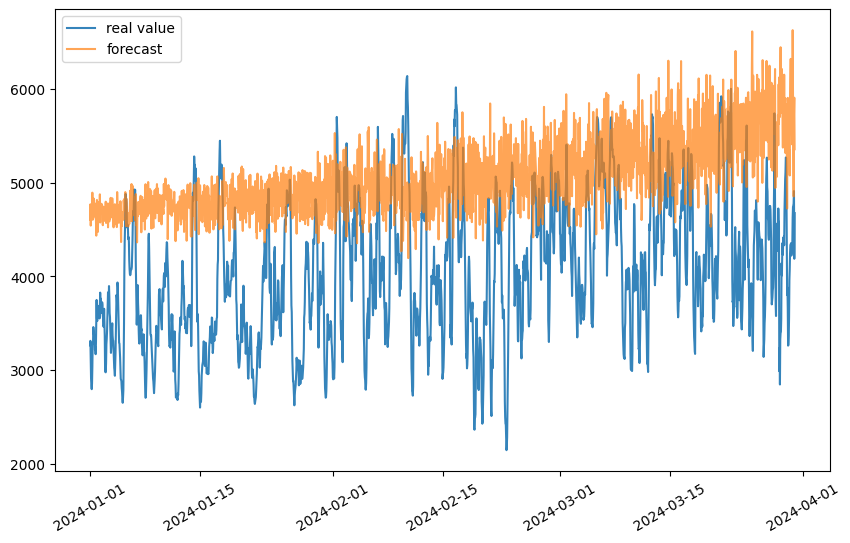

In [19]:
daterange = electricity_forecast.ds
plt.figure(figsize=(10, 6))
plt.plot(daterange, test.y.iloc[-OUR_HORIZON:], label='real value', alpha=0.9)
plt.plot(daterange, electricity_forecast.NBEATS, label='forecast', alpha=0.7)
plt.tick_params(axis='x', rotation=30)
plt.legend();

In [20]:
calculate_mae = MAE()
calculate_mae.__call__(y=torch.tensor(test.y.iloc[-OUR_HORIZON:].to_numpy()), 
                       y_hat=torch.tensor(electricity_forecast.NBEATS.to_numpy()))

tensor(1078.8324)